In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import clip
from scripts.clip_wrapper import ClipWrapper
from scripts.plot import visualize_vandt_heatmap
from scripts.methods import vision_heatmap_iba, text_heatmap_iba
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast
from PIL import Image, ImageOps
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import math
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
def plot(model, vmap,image, text, vbeta=0.1, vvar=1, vlayer=9, tbeta=0.1, tvar=1, tlayer=9, bb=None, ):
    # Preprocess image
    # image = Image.open(image).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device) # 3*224*224
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    # Train information bottleneck on image
    print("Training M2IB on the image...")
    # vmap = vision_heatmap_iba(text_ids, image_feat, model, vlayer, vbeta, vvar)
    # Train information bottleneck on text
    print("Training M2IB on the text...")
    tmap = text_heatmap_iba(text_ids, image_feat, model, tlayer, tbeta, tvar)
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    if bb:
        scaled_bb = []
        for x, y, w, h in bb:
            hr, vr = image_under.shape[0]/image.size[0], image_under.shape[1]/image.size[1]
            scaled_bb.append((x*hr, y*vr, w*hr, h*vr))
        bb = scaled_bb
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under, bb=bb)
    return vmap

In [18]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")


med_model, med_preprocess= clip.load("ViT-B/32", device=device)
med_model.load_state_dict(torch.load("../data/clip-imp-pretrained_128_6_after_4.pt", map_location=device))
med_model1 = ClipWrapper(med_model)

<class 'numpy.ndarray'>
(224, 224)
(1188, 1188)
Training M2IB on the image...
Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


array([[0.00128984, 0.00128984, 0.00128984, ..., 0.00161877, 0.00161877,
        0.00161877],
       [0.00128984, 0.00128984, 0.00128984, ..., 0.00161877, 0.00161877,
        0.00161877],
       [0.00128984, 0.00128984, 0.00128984, ..., 0.00161877, 0.00161877,
        0.00161877],
       ...,
       [0.00442658, 0.00442658, 0.00442658, ..., 0.01001726, 0.01001726,
        0.01001726],
       [0.00442658, 0.00442658, 0.00442658, ..., 0.01001726, 0.01001726,
        0.01001726],
       [0.00442658, 0.00442658, 0.00442658, ..., 0.01001726, 0.01001726,
        0.01001726]], dtype=float32)

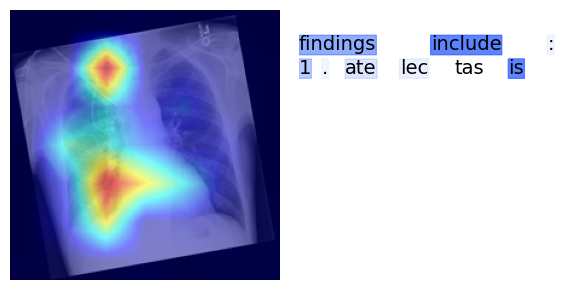

In [32]:
import pickle

# Open the file in binary read mode
with open("../out/00007557_026-10-crop0-image.pkl", "rb") as f:
    image = pickle.load(f)

with open("../out/00007557_026-10-crop0-bboxmask.pkl", "rb") as f:
    bbox_mask = pickle.load(f)

with open("../out/00007557_026-10-crop0-attrMap.pkl", "rb") as f:
    vmap = pickle.load(f)


print(type(vmap))
print(vmap[0].shape)


print(image.size)

# import matplotlib.pyplot as plt
# # Plot
# plt.imshow(image, cmap='gray')  # or use cmap='Reds' or 'hot'
# plt.title("Binary Mask")
# plt.axis('off')
# plt.colorbar()
# plt.show()



text = 'findings include: 1. ' + 'Atelectasis'

plot(med_model1,vmap[0], image, text,vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=None)



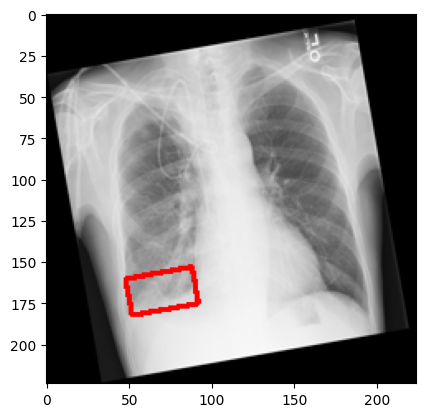

In [31]:
image = image.resize((224, 224), resample=Image.BICUBIC)
contours, _ = cv2.findContours((bbox_mask).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_with_contour = np.array(image).copy()
cv2.drawContours(image_with_contour, contours, -1, (0, 0, 255), thickness=2)  # Red line (BGR)
plt.imshow(cv2.cvtColor(image_with_contour, cv2.COLOR_BGR2RGB))

In [7]:
import pickle

with open('../out/result/00007557_026-rot-0-crp-0-result.pkl', 'rb') as f:
    data = pickle.load(f)


print(data)

[{'iou': 0.3256745934486389, 'precision': 0.33692649006843567, 'recall': 0.9069940447807312, 'f1': 0.49133415111279605, 'img': <PIL.Image.Image image mode=RGBA size=224x224 at 0x10D968CD0>}, {'iou': 0.42131438851356506, 'precision': 0.44636809825897217, 'recall': 0.882440447807312, 'f1': 0.5928517929548254, 'img': <PIL.Image.Image image mode=RGBA size=224x224 at 0x10DB25C40>}, {'iou': 0.46203815937042236, 'precision': 0.5042091012001038, 'recall': 0.8467261791229248, 'f1': 0.6320466301480904, 'img': <PIL.Image.Image image mode=RGBA size=224x224 at 0x10DB25F70>}]
